<a href="https://colab.research.google.com/github/VidhyaMadhavi/EVA/blob/master/Assignment14/Session_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ASSIGNMENT 14**


***GROUP MEMBERS: AYSWARYA, PAVAN, SMITA, VIDYA, YAMINI***

    1) Original model: 93%, 24 Epochs, 858 s
    2) Move the data to TFRecords
    3) Add Cutout
    4) Show the training logs and accuracy graphs
    


## **Import required libaries, set parameters**


In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from PIL import Image
import numpy as np
import skimage.io as io
from keras import backend as K

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


**Enable Eager Mode**

In [0]:
tf.enable_eager_execution()

**Set training parameters**

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

## **Create the Model**

**Initialization function similar to Pytorch**

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

### **Single Convolution Block**


In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

### **Residual block**

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

### **DavidNet Model or Main Model**

In [0]:
# Defing the David Net Model.

class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

## **Cutout Function**


### **Cutout Function 1**


Expects an array or image as input, so convert the tensor accordingly

In [0]:
from PIL import Image
class Cutout(object):
    def __init__(self, length=10):
        self.length = length

    def __call__(self, p, img):
      cutout_im = np.zeros_like(img)
      for i in range(img.shape[0]):
        p_1 = np.random.rand() 
        im = img[i]
        im = np.array(im)
        if p_1 > p:
          cutout_im[i] = im
        else:
          mask_val = im.mean()

          top = np.random.randint(0, im.shape[0])
          left = np.random.randint(0, im.shape[1])
          bottom = top + self.length
          right = left + self.length

          im[top:bottom, left:right, :] = mask_val

          im = Image.fromarray(im)
          cutout_im[i] = im
      return cutout_im

cutout=Cutout()

### **Cutout Function 2**

 - Needs a tensor Variable as input. Casting input image to variable gives error: 
 
 Tensor-typed variable initializers must either be wrapped in an init_scope or callable 

In [0]:

def random_erasing(img, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3):
    '''
    img is a 3-D variable (ex: tf.Variable(image, validate_shape=False) ) and  HWC order
    '''
    # HWC order
    
    with tf.init_scope():

      img = tf.Variable(tf.convert_to_tensor(img))
      height = tf.shape(img)[0]
      width = tf.shape(img)[1]
      channel = tf.shape(img)[2]
      area = tf.cast(width*height, tf.float32)

      erase_area_low_bound = tf.cast(tf.round(tf.sqrt(sl * area * r1)), tf.int32)
      erase_area_up_bound = tf.cast(tf.round(tf.sqrt((sh * area) / r1)), tf.int32)
      h_upper_bound = tf.minimum(erase_area_up_bound, height)
      w_upper_bound = tf.minimum(erase_area_up_bound, width)

      h = tf.random.uniform([], erase_area_low_bound, h_upper_bound, tf.int32)
      w = tf.random.uniform([], erase_area_low_bound, w_upper_bound, tf.int32)

      x1 = tf.random.uniform([], 0, height+1 - h, tf.int32)
      y1 = tf.random.uniform([], 0, width+1 - w, tf.int32)

      erase_area = tf.cast(tf.random.uniform([h, w, channel], 0, 255, tf.int32), tf.uint8)

      erasing_img = img[x1:x1+h, y1:y1+w, :].assign(erase_area)

      return tf.cond(tf.random.uniform([], 0, 1) > probability, lambda: img, lambda: erasing_img)

## **Load the Dataset and initialize the Model**

###**Loading the Dataset and then Normalizing it**


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 4s 0us/step


### **Defining the Optimization Strategies**

In [0]:
# Defining the Optimization Strategies.

model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

def to_numpy(t):
  print("Inside to_numpy:", type(t.numpy()))
  t.numpy()

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
#data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(cutout(0.3, tf.py_function(to_numpy, [x], tf.float32)), [32, 32, 3])), y)


**Note: Using Cutout:** 

 - The cutout function expects a numpy array, but inside the lambda function we have a tensor. Lambda function itself is used within a map
 - Eager execution mode does not work inside maps, since they get converted to Graph mode. Using tf.py_function explicitly to force eager execution did not work as well
 - We tried a second cutout function which used tf.Variable as input, but could not fix the error
 - Have not used the cutout function in the data augmentation part since we could not get this to work

## **Using TfRecords**


    train_tfrecords_filename = 'TrainCifar10.tfrecords'
    test_tfrecords_filename = 'TestCifar10.tfrecords'



### **Encoding dataset to TfRecords**

In [0]:
#Defining parameters

IMAGE_HEIGHT = 40
IMAGE_WIDTH = 40
IMAGE_DEPTH = 3
NUM_CLASSES = 10

# ENCODING
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))



def _convert_to_tfrecord(data, labels, tfrecords_filename):
  """Converts a file to TFRecords."""
  print('Generating %s' % tfrecords_filename)
  with tf.python_io.TFRecordWriter(tfrecords_filename) as record_writer:
    num_entries_in_batch = len(labels)
    for i in range(num_entries_in_batch):
      example = tf.train.Example(features=tf.train.Features(
        feature={
          'image': _bytes_feature(data[i].tobytes()),
          'label': _int64_feature(labels[i])
        }))
      record_writer.write(example.SerializeToString())



train_tfrecords_filename = 'TrainCifar10.tfrecords'
test_tfrecords_filename = 'TestCifar10.tfrecords'

_convert_to_tfrecord(x_train, y_train,train_tfrecords_filename)
_convert_to_tfrecord(x_test,y_test,test_tfrecords_filename)



Generating TrainCifar10.tfrecords
Generating TestCifar10.tfrecords


### **Decoding the dataset from TfRecords**

In [0]:
#DECODING

def parse_record(serialized_example, isTraining = True):
  features = tf.parse_single_example(
    serialized_example,
    features={
      'image': tf.FixedLenFeature([], tf.string),
      'label': tf.FixedLenFeature([], tf.int64),
    })
  
  image = features['image']
  image = tf.decode_raw(image, tf.float32)

  if(isTraining):
    image = tf.reshape(image, [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
  else:
    image = tf.reshape(image, [32, 32, IMAGE_DEPTH])
  
  label = tf.cast(features['label'], tf.int64)
  return image, label

def generate_input_fn(file_name, isTraining = True):
  dataset = tf.data.TFRecordDataset(filenames=file_name)
  dataset = dataset.map(lambda x: parse_record(x, isTraining))
  return dataset  


## **Training the model**

Traing the dataset after decoding, and printing out the validation accuracy.

In [0]:
t = time.time()
test_set = generate_input_fn(test_tfrecords_filename, isTraining=False).batch(BATCH_SIZE)

hist_train_acc = []
hist_train_loss = []
hist_val_acc = []
hist_val_loss = []

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = generate_input_fn(train_tfrecords_filename).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  tf.keras.backend.set_learning_phase(1)

  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    


  # Save data for plotting
  hist_train_acc.append(train_acc / len_train)
  hist_train_loss.append(train_loss / len_train)
  hist_val_acc.append(test_acc / len_test)
  hist_val_loss.append(test_loss / len_test)

  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.578544017944336 train acc: 0.42982 val loss: 1.1842616180419923 val acc: 0.5695 time: 56.93087697029114



epoch: 2 lr: 0.16 train loss: 0.8444538723754883 train acc: 0.69986 val loss: 0.7152764236450195 val acc: 0.7576 time: 92.4326720237732



epoch: 3 lr: 0.24 train loss: 0.6396186111450195 train acc: 0.77816 val loss: 0.7394735534667969 val acc: 0.7519 time: 128.13221096992493



epoch: 4 lr: 0.32 train loss: 0.5407170877075196 train acc: 0.81272 val loss: 0.6801636016845704 val acc: 0.7854 time: 164.76531505584717



epoch: 5 lr: 0.4 train loss: 0.46718676422119143 train acc: 0.83912 val loss: 0.554982371520996 val acc: 0.8184 time: 201.83764719963074



epoch: 6 lr: 0.37894736842105264 train loss: 0.38904830535888674 train acc: 0.86612 val loss: 0.4567980651855469 val acc: 0.8448 time: 238.57715678215027



epoch: 7 lr: 0.35789473684210527 train loss: 0.3170300567626953 train acc: 0.889 val loss: 0.4649271957397461 val acc: 0.847 time: 275.79832911491394



epoch: 8 lr: 0.33684210526315794 train loss: 0.2665933625793457 train acc: 0.90782 val loss: 0.44477716827392577 val acc: 0.8553 time: 312.9166133403778



epoch: 9 lr: 0.31578947368421056 train loss: 0.2336080062866211 train acc: 0.91884 val loss: 0.3813902526855469 val acc: 0.8759 time: 349.7592751979828



epoch: 10 lr: 0.2947368421052632 train loss: 0.20036285095214842 train acc: 0.93032 val loss: 0.3767037910461426 val acc: 0.8783 time: 386.5623004436493



epoch: 11 lr: 0.2736842105263158 train loss: 0.16874366844177247 train acc: 0.94152 val loss: 0.35011287689208986 val acc: 0.8893 time: 423.3667240142822



epoch: 12 lr: 0.25263157894736843 train loss: 0.1510687336730957 train acc: 0.94792 val loss: 0.35026066665649414 val acc: 0.8884 time: 460.14808225631714



epoch: 13 lr: 0.23157894736842108 train loss: 0.12658340553283692 train acc: 0.95754 val loss: 0.32034756698608396 val acc: 0.8984 time: 497.0959060192108



epoch: 14 lr: 0.2105263157894737 train loss: 0.11097607940673829 train acc: 0.96178 val loss: 0.3232458557128906 val acc: 0.9028 time: 533.8959572315216



epoch: 15 lr: 0.18947368421052635 train loss: 0.09334544734954835 train acc: 0.96904 val loss: 0.28605179595947267 val acc: 0.9119 time: 571.002622127533



epoch: 16 lr: 0.16842105263157897 train loss: 0.07886921562194824 train acc: 0.97436 val loss: 0.28551625442504885 val acc: 0.9131 time: 607.8177967071533



epoch: 17 lr: 0.1473684210526316 train loss: 0.06431619300842285 train acc: 0.979 val loss: 0.3125024383544922 val acc: 0.9094 time: 644.6014761924744



epoch: 18 lr: 0.12631578947368421 train loss: 0.054820148849487306 train acc: 0.98254 val loss: 0.27839563941955564 val acc: 0.9194 time: 681.35080909729



epoch: 19 lr: 0.10526315789473689 train loss: 0.04324108999252319 train acc: 0.98724 val loss: 0.27621821517944334 val acc: 0.9212 time: 717.9773371219635



epoch: 20 lr: 0.08421052631578951 train loss: 0.03833139015197754 train acc: 0.98808 val loss: 0.2591748725891113 val acc: 0.9239 time: 754.9989795684814



epoch: 21 lr: 0.06315789473684214 train loss: 0.029671938619613647 train acc: 0.9917 val loss: 0.25960623435974123 val acc: 0.9264 time: 791.8534581661224



epoch: 22 lr: 0.04210526315789476 train loss: 0.024919526968002318 train acc: 0.9935 val loss: 0.2561768333435059 val acc: 0.9289 time: 828.5721719264984



epoch: 23 lr: 0.02105263157894738 train loss: 0.021100108981132508 train acc: 0.99448 val loss: 0.2526348625183105 val acc: 0.9289 time: 865.5073690414429



epoch: 24 lr: 0.0 train loss: 0.01890345358848572 train acc: 0.99578 val loss: 0.25170478172302246 val acc: 0.9291 time: 902.1523098945618


### **Plotting training and validation accuracy and loss**

In [0]:
history = {}
history['acc'] = hist_train_acc
history['val_acc'] = hist_val_acc
history['loss'] = hist_train_loss
history['val_loss'] = hist_val_loss


"\nhistory_big = {}\nhistory_big['acc'] = hist_train_acc_big\nhistory_big['val_acc'] = hist_val_acc_big\nhistory_big['loss'] = hist_train_loss_big\nhistory_big['val_loss'] = hist_val_loss_big\n\n\nprint(len(hist_train_acc_big))\nprint(len(hist_val_acc_big))\n"

In [0]:
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline


def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(history['acc'])+1),history['acc'])
    axs[0].plot(range(1,len(history['val_acc'])+1),history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history['acc'])+1),len(history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss
    axs[1].plot(range(1,len(history['loss'])+1),history['loss'])
    axs[1].plot(range(1,len(history['val_loss'])+1),history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history['loss'])+1),len(history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

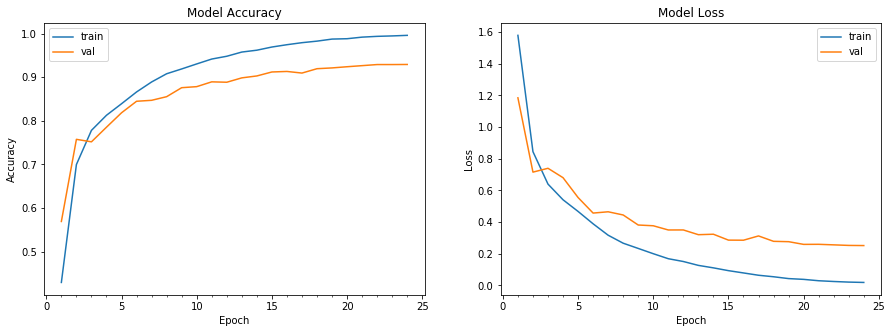

In [0]:
plot_model_history(history)

## **Summary**


So the final validation accuracy is = 93.96% in 24th EPOCH 

    epoch: 24
    lr: 0.0
    train loss: 0.020015651292800904
    train acc: 0.99544
    val loss: 0.2513535671234131
    val acc: 0.93
    

